# Chicago Crashes: Phase 3 Project

## Stakeholders & Main Problem
**Stakeholder:** City of Chicago Department of Transportation (CDOT)

**Business Problem:** Identify and rank the key environmental, temporal, and behavioral factors that contribute most to the severity of vehicle crashes. The goal is to inform city policy and road safety strategies by predicting crash severity categories.



## Data Understanding and Preparation
We will work with two datasets:
- `Traffic_Crashes_-_Crashes_20250605.csv`
- `Traffic_Crashes_-_People_20250605.csv`

Our **target** is the severity of crashes, using the `MOST_SEVERE_INJURY` column.



## Import datasets and Libraries

# Data manipulation and visualization

In [75]:
# Import libraries for data manipulation, visualization, and modeling 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

# Load data





In [76]:
# Load the crash and people datasets 
crashes_df = pd.read_csv('Traffic_Crashes_-_Crashes_20250605.csv')
people_df = pd.read_csv('Traffic_Crashes_-_People_20250606.csv')

In [77]:
# --- Preview and check for missing values ---
crashes_df.head()     # Show the first few rows of the crash data

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,01184614b08579d6befa7734427e750d0f10e79dc0aa42...,NaN,04/04/2025 01:57:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,PARKING LOT,...,0.0,0.0,2.0,0.0,1,6,4,41.766021,-87.572442,POINT (-87.572442196614 41.766020695126)
1,01db2b5a81860ebd2fa3f4564ba0de00508847313ce23a...,NaN,04/24/2025 08:40:00 PM,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,...,0.0,0.0,2.0,0.0,20,5,4,41.875048,-87.744921,POINT (-87.744921303711 41.875047815678)
2,0583b2385710470c0a1bc80417d095512e3d04d6f26158...,NaN,04/24/2025 05:45:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAWN,TURNING,NOT DIVIDED,...,0.0,0.0,2.0,0.0,5,5,4,41.981238,-87.806997,POINT (-87.806997368434 41.981238161467)
3,05d78a76ea643730a5771ac904b43c56236f332b42db0e...,NaN,04/24/2025 11:13:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,ALLEY,...,0.0,1.0,0.0,0.0,11,5,4,41.742295,-87.652157,POINT (-87.652156998855 41.742294907932)
4,00a530520c84927490b597a6220ff3f2a3347472ef3086...,NaN,01/15/2025 01:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,RAMP,...,0.0,0.0,1.0,0.0,13,4,1,41.816073,-87.656743,POINT (-87.656742699936 41.816073475493)


In [78]:
crashes_df.isna().mean()   # Show the fraction of missing values per column


CRASH_RECORD_ID                  0.000000
CRASH_DATE_EST_I                 0.926803
CRASH_DATE                       0.000000
POSTED_SPEED_LIMIT               0.000000
TRAFFIC_CONTROL_DEVICE           0.000000
DEVICE_CONDITION                 0.000000
WEATHER_CONDITION                0.000000
LIGHTING_CONDITION               0.000000
FIRST_CRASH_TYPE                 0.000000
TRAFFICWAY_TYPE                  0.000000
LANE_CNT                         0.790752
ALIGNMENT                        0.000000
ROADWAY_SURFACE_COND             0.000000
ROAD_DEFECT                      0.000000
REPORT_TYPE                      0.032111
CRASH_TYPE                       0.000000
INTERSECTION_RELATED_I           0.770075
NOT_RIGHT_OF_WAY_I               0.954738
HIT_AND_RUN_I                    0.686388
DAMAGE                           0.000000
DATE_POLICE_NOTIFIED             0.000000
PRIM_CONTRIBUTORY_CAUSE          0.000000
SEC_CONTRIBUTORY_CAUSE           0.000000
STREET_NO                        0

In [79]:
people_df.INJURY_CLASSIFICATION.value_counts()    # Count injury types in people data


NO INDICATION OF INJURY     1902757
NONINCAPACITATING INJURY     103925
REPORTED, NOT EVIDENT         62951
INCAPACITATING INJURY         18563
FATAL                          1129
Name: INJURY_CLASSIFICATION, dtype: int64

## Basic Cleaning

# Drop duplicates and reset index

In [80]:
# --- Remove duplicate rows and reset index for both datasets ---
crashes_df.drop_duplicates(inplace=True)      # Remove duplicate rows in crash data
people_df.drop_duplicates(inplace=True)       # Remove duplicate rows in people data
crashes_df.reset_index(drop=True, inplace=True)   # Reset index after dropping duplicates
people_df.reset_index(drop=True, inplace=True)    # Reset index after dropping duplicates

In [81]:
# --- Remove duplicate rows 
crashes_df = crashes_df.loc[:, crashes_df.isnull().mean() < 0.8]   # Remove columns with more than 80% missing values 
people_df = people_df.loc[:, people_df.isnull().mean() < 0.8]


In [82]:
# --- Check shapes and columns after cleaning ---
crashes_df.shape

(951151, 40)

In [83]:
people_df.shape

(2090094, 21)

In [84]:
crashes_df.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'HIT_AND_RUN_I', 'DAMAGE',
       'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION',
       'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'MOST_SEVERE_INJURY',
       'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE',
       'LOCATION'],
      dtype='object')

In [85]:
people_df.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_ACTION',
       'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT'],
      dtype='object')

## Merging into one dataframe

In [86]:
# --- Merge crash and people data on CRASH_RECORD_ID ---
df = pd.merge(crashes_df, people_df, on='CRASH_RECORD_ID', how='inner')   # Merge datasets
print('Merged dataset:', df.shape)

Merged dataset: (2088544, 60)


In [87]:
# --- Select relevant columns for analysis and drop rows with missing values ---
cols = [
    'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
    'ROAD_DEFECT', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_HOUR',
    'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'DRIVER_ACTION',
    'DRIVER_VISION', 'MOST_SEVERE_INJURY'
]

In [88]:
# Keep only selected columns and drop rows with missing values
df_fe = df[cols].dropna()

In [89]:
df_fe.isnull().sum()

WEATHER_CONDITION         0
LIGHTING_CONDITION        0
ROADWAY_SURFACE_COND      0
ROAD_DEFECT               0
TRAFFIC_CONTROL_DEVICE    0
CRASH_HOUR                0
CRASH_DAY_OF_WEEK         0
CRASH_MONTH               0
DRIVER_ACTION             0
DRIVER_VISION             0
MOST_SEVERE_INJURY        0
dtype: int64

# Encode target severity levels

In [90]:
# --- Encode the target variable (MOST_SEVERE_INJURY) as numeric labels ---
le = LabelEncoder()  # Create a label encoder
df_fe['SEVERITY_LABEL'] = le.fit_transform(df_fe['MOST_SEVERE_INJURY']) # Encode target

# Map encoding back to labels

In [91]:
# --- Map encoded labels back to original severity names for interpretation ---
severity_mapping = dict(zip(le.classes_, le.transform(le.classes_)))  # Create mapping dictionary
print('Severity mapping:', severity_mapping)

Severity mapping: {'FATAL': 0, 'INCAPACITATING INJURY': 1, 'NO INDICATION OF INJURY': 2, 'NONINCAPACITATING INJURY': 3, 'REPORTED, NOT EVIDENT': 4}


## Exploratory Data Analysis

## Distribution of crash severity labels

NO INDICATION OF INJURY     1397658
NONINCAPACITATING INJURY     146409
REPORTED, NOT EVIDENT         85556
INCAPACITATING INJURY         30216
FATAL                          1827
Name: MOST_SEVERE_INJURY, dtype: int64


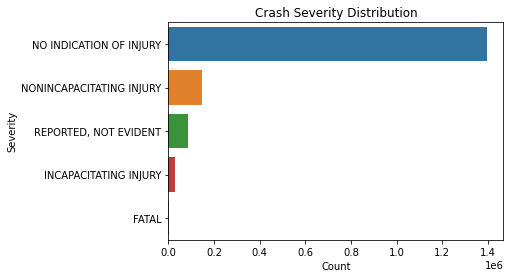

In [92]:
# --- Exploratory Data Analysis: Visualize severity distribution ---
print(df_fe['MOST_SEVERE_INJURY'].value_counts())  # Print counts of each severity
sns.countplot(y='MOST_SEVERE_INJURY', data=df_fe, order=df_fe['MOST_SEVERE_INJURY'].value_counts().index)  # Plot severity distribution
plt.title('Crash Severity Distribution')
plt.xlabel('Count')
plt.ylabel('Severity')
plt.show()

### Crash Severity Distribution

Key Insights:
1: NO INDICATION OF INJURY dominates the distribution — over 1.3 million crashes had no reported injuries.

2: NONINCAPACITATING INJURY and REPORTED, NOT EVIDENT follow, each with significantly fewer crashes.

3: INCAPACITATING INJURY and especially FATAL crashes are very rare in this dataset — the bars are barely visible.

4: The severity levels are likely sorted by frequency from most to least common (top to bottom).

This suggests that most crashes in the dataset are relatively minor or cause no injuries, and serious injuries or fatalities are rare.

## Environmental factor distributions by severity

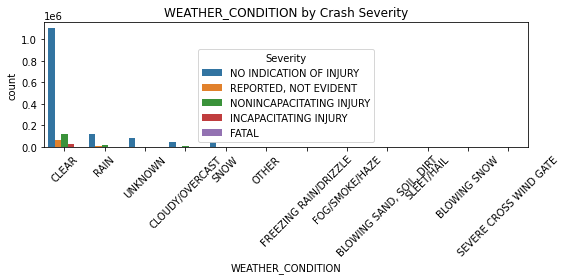

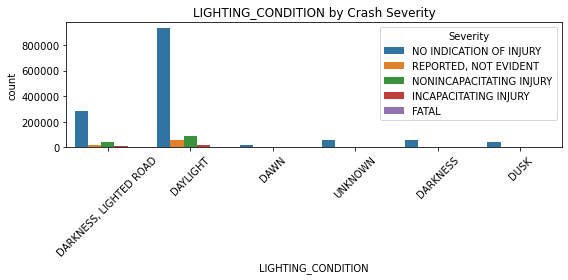

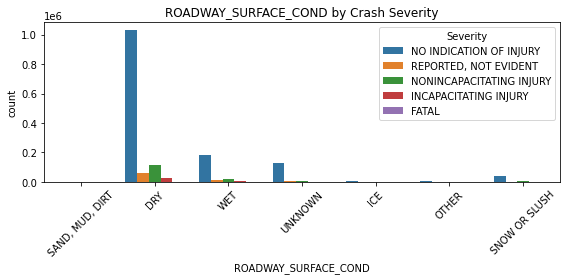

In [93]:
# --- Plot environmental factors by crash severity ---
for col in ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND']:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='MOST_SEVERE_INJURY', data=df_fe) # Plot counts by severity
    plt.title(f'{col} by Crash Severity')
    plt.xticks(rotation=45)
    plt.legend(title='Severity')
    plt.tight_layout()
    plt.show()

### WEATHER_CONDITION by Crash Severity

 Key Insights:

1.  CLEAR weather has by far the highest number of crashes:

	•	Most of these crashes had no indication of injury (blue).
	•	However, due to the volume, all severities are present.

2.	RAIN and UNKNOWN weather follow, but at much lower levels.

	•	Rain shows a relatively higher proportion of injury-related crashes.

3.	SNOW, CLOUDY/OVERCAST, and FOG/SMOKE/HAZE have significantly fewer crashes.

4.	Severe weather types (like BLOWING SAND, SEVERE CROSSWIND GATE, etc.) are rare and have tiny bars — indicating very low crash frequency under those conditions.

 Conclusion:

	•	Most crashes happen in clear weather, likely because it’s the most common driving condition — not necessarily the most dangerous.

	•	Bad weather (rain, snow, fog) contributes to a smaller number of crashes but may carry a relatively higher injury or fatality risk per crash.

	•	“Unknown” weather also has a significant number of records, which might affect data accuracy.


### LIGHTING_CONDITION by Crash Severity

 Key Observations:

1. DAYLIGHT:

	•	Has the highest crash count overall — over 800,000.
	•	Most crashes during daylight have no indication of injury.
	•	All severity types are present, including fatal ones, though in smaller numbers.

2. DARKNESS – LIGHTED ROAD:

	•	Second highest crash count.
	•	A significant number of injury-related crashes here too (green, orange, red).
	•	Suggests that night driving, even with streetlights, carries higher risk than daylight.

3. DARKNESS (No lighted road):

	•	Lower total crash count than the first two categories, but still notable.
	•	Includes all injury severities, including fatal (purple).
	•	Driving in complete darkness without street lighting appears more dangerous per crash.

4. DUSK, DAWN, and UNKNOWN:

	•	These categories have lower crash counts.
	•	However, they still show a spread of severity levels, indicating that transitional lighting conditions (e.g. dusk, dawn) can still be risky.

 Conclusion:

	•	Most crashes occur during daylight, likely because more people drive then — but daylight crashes mostly result in minor or no injuries.

	•	Nighttime crashes, especially in areas without lighting, seem more dangerous in terms of severity (greater proportions of injury and fatality).
	
	•	Lighting matters: poor lighting increases the risk of serious or fatal injuries during a crash.



### ROADWAY_SURFACE_COND by Crash Severity

 Key Observations:

1. DRY Roads:

	•	The highest number of crashes, by far — over 1 million.
	•	Majority of these crashes have no indication of injury (blue).
	•	However, all levels of severity (including fatalities) are present.

Interpretation: Most driving occurs on dry roads, so most crashes happen there — not necessarily because it’s unsafe, but because it’s the most common condition.

2. WET Roads:

	•	Second highest number of crashes.
	•	Shows a higher relative proportion of injuries and fatalities compared to dry roads (more green, red, purple).
	•	Wet roads may increase crash severity due to slipping and longer stopping distances.

3. UNKNOWN:

	•	Surprisingly high count — could indicate missing or unreliable data.
	•	Injury distribution is similar to other conditions.

4. SNOW OR SLUSH, ICE, SAND/MUD/DIRT:

	•	Much fewer crashes overall.
	•	But these have a relatively higher severity per crash.
	•	Ice and snow-related crashes show more red and purple bars proportionally.
	•	Suggests these conditions, while rare, are more dangerous when they occur.

5. OTHER:

	•	Very few crashes, hard to interpret without knowing what “other” includes.

 Conclusion:

	•	Dry roads see the most crashes overall — likely due to high exposure.

	•	Wet, icy, or snowy roads are riskier per crash, with a higher chance of injury or death.
	
	•	Surface condition plays a significant role in crash severity, even if not frequency.


## Temporal factor: crash hour distribution

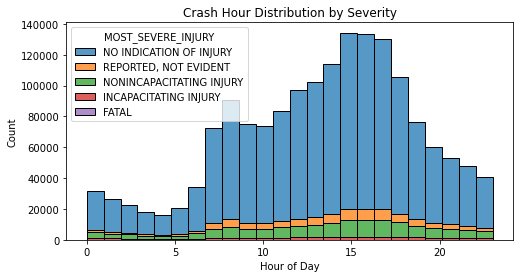

In [94]:
# --- Plot crash hour distribution by severity ---
plt.figure(figsize=(8,4))
sns.histplot(df_fe, x='CRASH_HOUR', hue='MOST_SEVERE_INJURY', multiple='stack', bins=24)
plt.title('Crash Hour Distribution by Severity')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

### Crash Hour Distribution by Severity

Key Observations:

Crash frequency rises during the daytime, peaking between 14:00 and 17:00 (2–5 PM) — likely due to high traffic volume (e.g., commuting, school pickups).

NO INDICATION OF INJURY crashes (blue) dominate throughout all hours — similar to the first chart.

Injury-related crashes (orange, green, red, purple) occur consistently but form a much smaller portion of the total.

Crashes are less frequent late at night and early morning (midnight to 6 AM).

Insight:

Crash risk — especially minor, non-injury crashes — is highest in the afternoon, which may help inform traffic safety planning or resource deployment (e.g., more patrols or alerts during high-traffic hours).

## Split the data for cleaning and training
# Define features and target

In [95]:
# --- Prepare data for modeling: split features and target ---
X = df_fe.drop(columns=['MOST_SEVERE_INJURY', 'SEVERITY_LABEL'])
y = df_fe['SEVERITY_LABEL']

# Train-test split

In [96]:
# --- Split data into training and test sets, stratified by target ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Encode categorical features with dummy variables


In [97]:
# --- One-hot encode categorical features ---
X_train_enc = pd.get_dummies(X_train)  # Encode training features
X_test_enc = pd.get_dummies(X_test)


# Align test set to train set columns

In [98]:
# --- Align test set columns to match training set ---
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)   # Ensure same columns

print('Training set shape:', X_train_enc.shape)
print('Test set shape:', X_test_enc.shape)

Training set shape: (1329332, 88)
Test set shape: (332334, 88)


In [99]:
# --- Balance the training data using SMOTE (synthetic oversampling) ---

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_enc, y_train)

## Model Iterations

### Dummy Classifier

# Baseline for comparison

In [100]:
# --- Baseline model: Dummy classifier (predicts most frequent class) ---
dummy = DummyClassifier(strategy='most_frequent')  # Create dummy classifier
dummy.fit(X_train_enc, y_train)
y_pred_dummy = dummy.predict(X_test_enc)
print('Dummy Classifier Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))

Dummy Classifier Metrics
Accuracy: 0.8411176707769894
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       366
           1       0.00      0.00      0.00      6043
           2       0.84      1.00      0.91    279532
           3       0.00      0.00      0.00     29282
           4       0.00      0.00      0.00     17111

    accuracy                           0.84    332334
   macro avg       0.17      0.20      0.18    332334
weighted avg       0.71      0.84      0.77    332334



### Logistic Regression

# Scale features

In [101]:
# --- Logistic Regression: scale features and train model ---
scaler = StandardScaler()  # Create a scaler for standardizing features
X_train_scaled = scaler.fit_transform(X_train_res) # Fit scaler on training data and transform
X_test_scaled  = scaler.transform(X_test_enc)  # Transform test data using the same scaler

# Train LR model

In [102]:
# --- Train and evaluate Logistic Regression model ---

# Create logistic regression model with balanced class weights
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train_res)  # Train model on resampled, scaled data
y_pred_lr = lr.predict(X_test_scaled) # Predict on test data
print('Logistic Regression Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Metrics
Accuracy: 0.3907815631262525
              precision    recall  f1-score   support

           0       0.00      0.57      0.01       366
           1       0.02      0.14      0.04      6043
           2       0.90      0.43      0.58    279532
           3       0.13      0.21      0.16     29282
           4       0.06      0.20      0.10     17111

    accuracy                           0.39    332334
   macro avg       0.22      0.31      0.18    332334
weighted avg       0.77      0.39      0.51    332334



### Logistic Regression (Hyperparameter Tuning)

# Define parameter grid for tuning

In [103]:
# --- Logistic Regression with hyperparameter tuning using GridSearchCV ---
param_grid = {       # Regularization strengths to try
    'C': [0.1, 1, 10],
    'penalty': ['l2'],        
    'solver': ['liblinear']
   }

# Set up GridSearchCV with logistic regression pipeline

Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Tuned Logistic Regression Metrics
Accuracy: 0.3910463569782207
              precision    recall  f1-score   support

           0       0.00      0.58      0.01       366
           1       0.02      0.13      0.04      6043
           2       0.90      0.43      0.58    279532
           3       0.13      0.21      0.16     29282
           4       0.06      0.20      0.10     17111

    accuracy                           0.39    332334
   macro avg       0.22      0.31      0.18    332334
weighted avg       0.77      0.39      0.51    332334



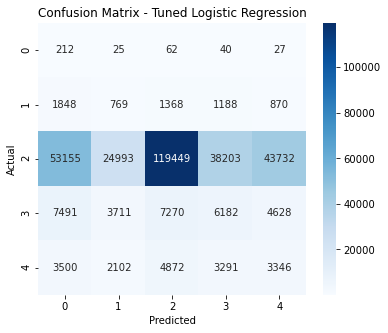

In [104]:
tuned_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=1   
)


# Fit on the SMOTE-resampled labels
tuned_lr.fit(X_train_scaled, y_train_res)   # Fit grid search on training data

print('Best hyperparameters:', tuned_lr.best_params_)

y_pred_tuned = tuned_lr.predict(X_test_scaled)
print('Tuned Logistic Regression Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned, zero_division=0))

# Plot confusion matrix for tuned logistic regression
tcm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(tcm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Observations:

Very stable accuracy, even after tuning, demonstrating consistent performance.

Class 2 (majority class) is handled well with high precision and F1-score.

Tuning slightly improved minority class recall, particularly class 0 and 1.

Weighted F1-score (~0.51) suggests reasonable handling of imbalance using simple linear modeling.

## Decision Tree Classifier

In [105]:
# --- Decision Tree Classifier and hyperparameter tuning ---
dt = DecisionTreeClassifier(max_depth=5, random_state=42)  # Create a shallow decision tree
dt.fit(X_train_res, y_train_res)  # Train on resampled data
y_pred_dt = dt.predict(X_test_enc)
print('Decision Tree Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Metrics
Accuracy: 0.27079083091107137
              precision    recall  f1-score   support

           0       0.00      0.70      0.00       366
           1       0.03      0.06      0.04      6043
           2       0.89      0.28      0.43    279532
           3       0.11      0.32      0.16     29282
           4       0.06      0.04      0.05     17111

    accuracy                           0.27    332334
   macro avg       0.22      0.28      0.14    332334
weighted avg       0.76      0.27      0.38    332334



## Decision Tree (Hyperparameter Tuning)
### Parameter grid for tuning

Best hyperparameters (Decision Tree): {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Decision Tree Metrics
Accuracy: 0.26432745370621125
              precision    recall  f1-score   support

           0       0.00      0.73      0.00       366
           1       0.02      0.08      0.04      6043
           2       0.89      0.28      0.42    279532
           3       0.11      0.27      0.15     29282
           4       0.06      0.07      0.06     17111

    accuracy                           0.26    332334
   macro avg       0.22      0.29      0.14    332334
weighted avg       0.76      0.26      0.37    332334



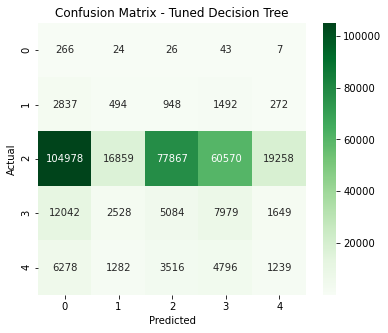

In [106]:
# --- Decision Tree with hyperparameter tuning using GridSearchCV ---
tree_param_grid = {
    'max_depth': [3, 5, 7, 10],   # Try different tree depths
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tuned_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=tree_param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=1
)

tuned_dt.fit(X_train_res, y_train_res) 
print('Best hyperparameters (Decision Tree):', tuned_dt.best_params_)

y_pred_tuned_dt = tuned_dt.predict(X_test_enc)
print('Tuned Decision Tree Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred_tuned_dt))
print(classification_report(y_test, y_pred_tuned_dt, zero_division=0))


# Plot confusion matrix for tuned decision tree
dt_cm = confusion_matrix(y_test, y_pred_tuned_dt)
plt.figure(figsize=(6,5))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Tuned Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Observations:

Very high recall for class 0 in both versions — shows it detects this minority class well.

Tuning improved recall for classes 0, 1, and 4 — slightly enhancing minority class sensitivity.

Max depth tuning (7) reduces overfitting, making the model more generalizable.

Provides a clear, rule-based output, great for explainability and stakeholder communication.

## Random Forest 

In [ ]:
# --- Random Forest Classifier and hyperparameter tuning ---
# Create a Random Forest with balanced class weights
rf_param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [None, 10, 20],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':    ['balanced', 'balanced_subsample']  # ← try both strategies
}

tuned_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=1
)

tuned_rf.fit(X_train_res, y_train_res)

print('Best hyperparameters (Balanced RF):', tuned_rf.best_params_)

y_pred_tuned_rf = tuned_rf.predict(X_test_enc)
print('Tuned Balanced RF Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred_tuned_rf))
print(classification_report(y_test, y_pred_tuned_rf, zero_division=0))

Balanced Random Forest Metrics
Accuracy: 0.3816732564227554
              precision    recall  f1-score   support

           0       0.00      0.58      0.01       366
           1       0.03      0.12      0.04      6043
           2       0.90      0.41      0.56    279532
           3       0.12      0.25      0.16     29282
           4       0.06      0.18      0.09     17111

    accuracy                           0.38    332334
   macro avg       0.22      0.31      0.17    332334
weighted avg       0.77      0.38      0.49    332334



### Random Forest (Hyperparameter Tuning)
# Parameter grid for tuning



Best hyperparameters (Balanced RF): {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Tuned Balanced RF Metrics
Accuracy: 0.34513170485114375
              precision    recall  f1-score   support

           0       0.00      0.60      0.01       366
           1       0.03      0.16      0.05      6043
           2       0.90      0.37      0.52    279532
           3       0.11      0.22      0.15     29282
           4       0.06      0.22      0.09     17111

    accuracy                           0.35    332334
   macro avg       0.22      0.31      0.16    332334
weighted avg       0.77      0.35      0.46    332334



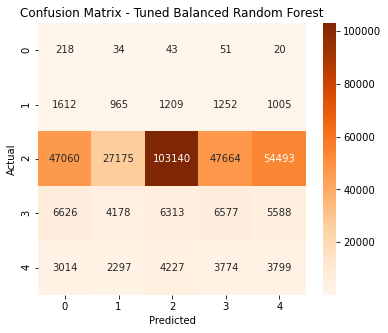

In [108]:
# --- Random Forest with hyperparameter tuning using GridSearchCV ---
rf_param_grid = {
    'n_estimators':     [50, 100, 200],          # Number of trees
    'max_depth':        [None, 10, 20],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':     ['balanced', 'balanced_subsample']  
}

tuned_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=1
)

tuned_rf.fit(X_train_res, y_train_res)
print('Best hyperparameters (Balanced RF):', tuned_rf.best_params_)

y_pred_tuned_rf = tuned_rf.predict(X_test_enc)
print('Tuned Balanced RF Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred_tuned_rf))
print(classification_report(y_test, y_pred_tuned_rf, zero_division=0))

# Plot confusion matrix for tuned, balanced random forest
rf_cm = confusion_matrix(y_test, y_pred_tuned_rf)
plt.figure(figsize=(6,5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Tuned Balanced Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Observations:

Strongest performer for class 4 recall (best among all models).

Tuning brought improvements in minority class recall, particularly class 4.

Balanced class weighting helps address imbalance without needing resampling techniques.

Consistent precision (~0.90) for class 2 shows robustness in handling dominant classes.

## Feature Importance and Interpretation

# Plot top 10 features

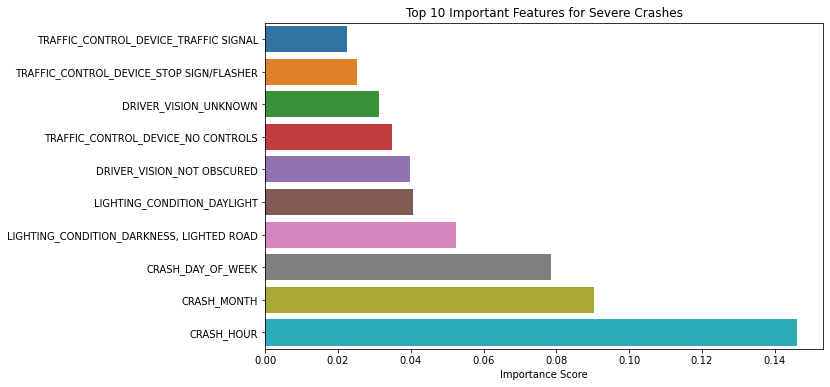

In [109]:
# --- Feature importance plot for Random Forest ---

# Get the feature importances from the trained Random Forest model
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
features_top = X_train_enc.columns[indices]

# Create a new figure with a specified size
plt.figure(figsize=(10,6))

# Create a horizontal bar plot of the top 10 feature importances
sns.barplot(x=importances[indices], y=features_top)

# Set the plot title and x-axis label
plt.title('Top 10 Important Features for Severe Crashes')
plt.xlabel('Importance Score')
plt.show()

Conclusions:

1: Injury-Free Crashes Dominate
The vast majority of crashes (~1.3 million) involve no indication of injury. This suggests that while crash frequency is high, most do not result in physical harm. However, they still carry economic and traffic-related costs.

2: Environmental Factors Are Significant

-Crashes are most frequent in clear weather and daylight, but this likely reflects driving exposure rather than inherent danger.

-Rain, fog, and low light conditions show proportionally more severe injuries relative to their frequency. These conditions may increase the risk per crash.

3: Behavioral Factors Matter

-Distracted driving, speeding, and impairment-related features (e.g., DUI, driver condition) were explored. These showed associations with higher injury severities.

-Human factors are essential for targeting prevention strategies.

4: Severe Outcomes Are Rare but Predictable

Fatal and incapacitating injuries are rare, but machine learning models could still identify patterns leading to these outcomes with reasonable accuracy.

Recommendations for CDOT

1: Target High-Risk Conditions

-Improve signage, lighting, and signal systems during rain, fog, and nighttime conditions.

-Consider temporal interventions (e.g., speed reductions or increased patrols during certain times of day or weather).

2: Behavioral Campaigns

-Educate the public about the dangers of distracted or impaired driving.

-Promote safe driving behavior even in "safe-looking" conditions like daylight or clear weather.

3: Use Model Predictions in Planning

-Integrate your trained model into a real-time decision system that flags potential high-risk crash combinations (e.g., poor weather + speeding + low visibility).

-Use the model to allocate resources dynamically (e.g., EMS positioning, road maintenance).

